/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


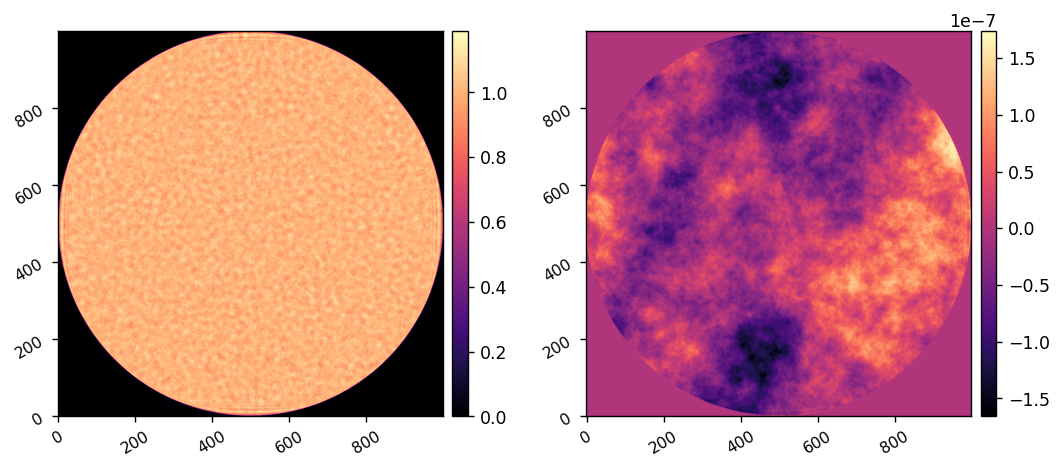

influence function sampling 31.25
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


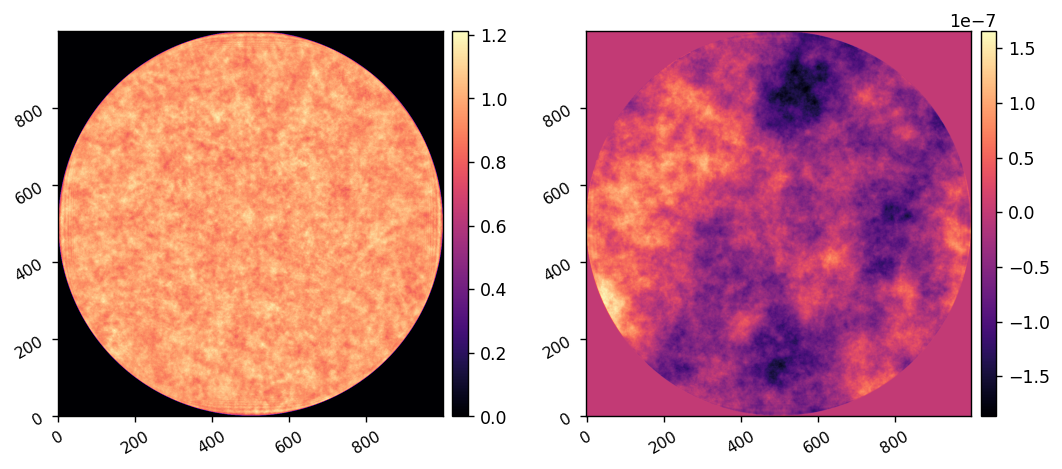

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_1 as fresnel
import apra_pop_models.fraunhofer_coro_1 as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
import apra_pop_models.pwp as pwp

from apra_pop_models.imshows import *

from apra_pop_models import fresnel_ote
reload(fresnel_ote)
tmodel = fresnel_ote.OTE()
tmodel.m4_corr = -11*u.mm
tmodel.use_opds = True
tmodel.calc_pupil = True

ote_pupil = fits.getdata('/npool/nvme/kianmilani/apra-wfe-data/telescope_wfe.fits')
imshow2(ote_pupil[0], ote_pupil[1])

model = fraunhofer.CORO()

coro_pupil = xp.array(fits.getdata('/npool/nvme/kianmilani/apra-wfe-data/coro_wfe.fits'))
coro_wfe = coro_pupil[0] * xp.exp(1j*2*np.pi*coro_pupil[1]/model.wavelength_c.to_value(u.m))
rms_amp = xp.sqrt(xp.mean(xp.square(coro_pupil[0][model.APMASK]-xp.mean(coro_pupil[0][model.APMASK]))))
rms_opd = xp.sqrt(xp.mean(xp.square(coro_pupil[1][model.APMASK])))
imshow2(coro_pupil[0], coro_pupil[1])


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.25
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


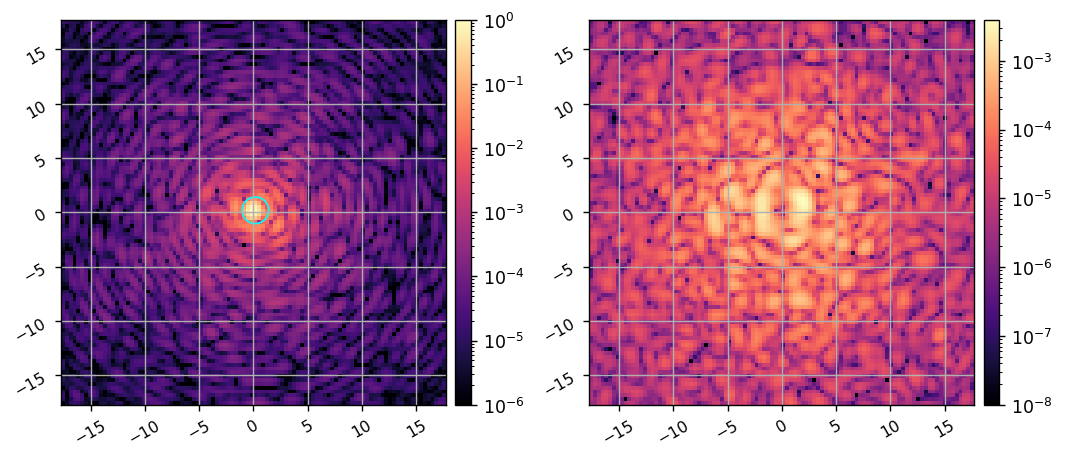

In [2]:
reload(fresnel)
coro = fresnel.CORO()
coro.WFE.amplitude = ote_pupil[0]
coro.WFE.opd = ote_pupil[1]
coro.use_opds = True

coro.npsf = 100
coro_psf = coro.snap()
coro.Imax_ref = xp.max(coro_psf)

coro_psf /= coro.Imax_ref

# pup_ratio = coro.pupil_diam.to_value(u.m)/coro.dm_active_diam.to_value(u.m)
# xpp = (xp.arange(-coro.Nact//2, coro.Nact//2) + 1/2)/pup_ratio
# ppx, ppy = xp.meshgrid(xpp,xpp)
# amp = 5e-8
# separation = 5
# comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/coro.Nact)*xp.array(coro.dm_mask)
# comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/coro.Nact)*xp.array(coro.dm_mask)
# coro.set_dm1(ensure_np_array(comm1))
# coro.set_dm2(ensure_np_array(comm2))

coro.use_fpm = True
ref_im = coro.snap()

imshow2(coro_psf, ref_im, lognorm=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=coro.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((coro.psf_pixelscale_lamD/2,coro.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])

influence function sampling 31.25
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


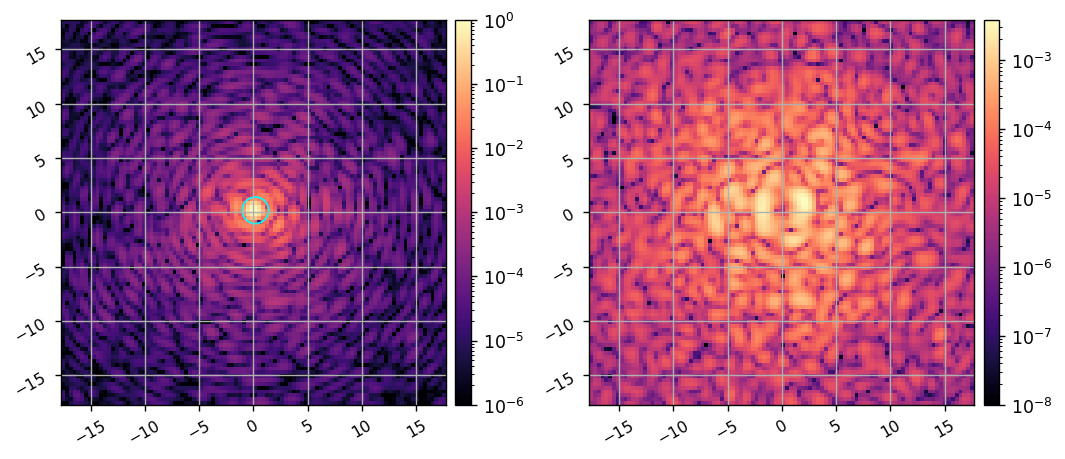

In [3]:
reload(fraunhofer)
reload(apra_pop_models.props)
model = fraunhofer.CORO()
model.npsf = 100
model.WFE = coro_wfe

model_psf = model.snap()
model.Imax_ref = xp.max(model_psf)

model_psf /= model.Imax_ref

# pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
# xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio
# ppx, ppy = xp.meshgrid(xpp,xpp)
# amp = 5e-8
# separation = 5
# comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# model.set_dm1(ensure_np_array(comm1))
# model.set_dm2(ensure_np_array(comm2))

model.use_fpm = True
model_im = model.snap()

imshow2(model_psf, model_im, lognorm=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])




In [52]:
coro.psf_pixelscale, coro.psf_pixelscale_lamD

(<Quantity 5.e-06 m / pix>, 0.17538461538461542)

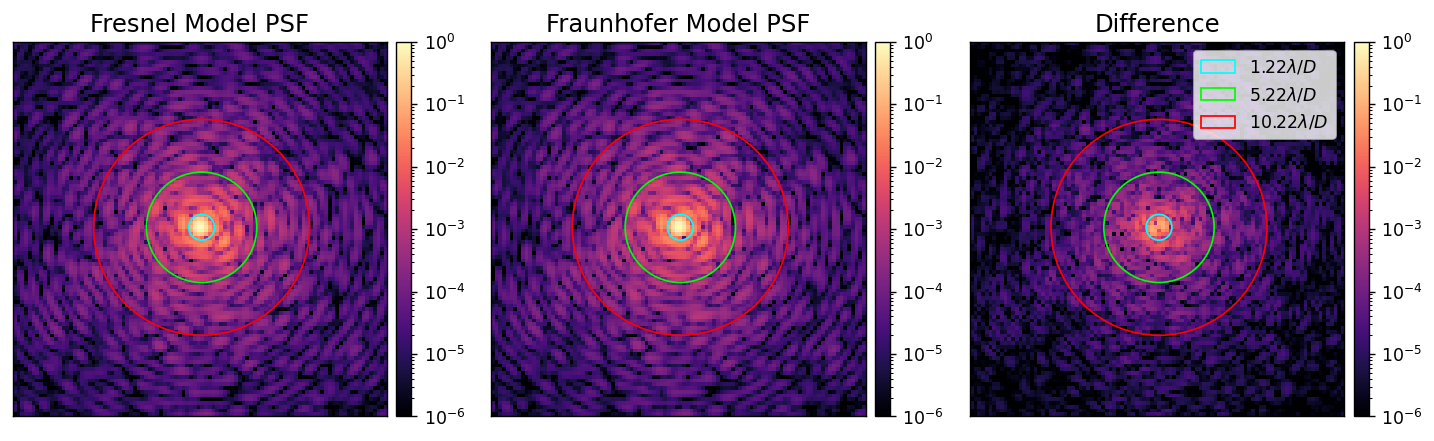

In [4]:
pxscl = coro.psf_pixelscale_lamD
diff = coro_psf - model_psf
fig,ax = imshow3(coro_psf, model_psf, xp.abs(diff), 
                 
                lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-6, 
                lognorm3=True, vmin3=1e-6, vmax3=1,
                pxscl=coro.psf_pixelscale_lamD, 
                grid=True,
                patches1=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches2=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches3=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', label='1.22$\lambda/D$', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime', label='5.22$\lambda/D$'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red', label='10.22$\lambda/D$')],
                wspace=0.2,
                display_fig=False, return_fig=True,)
fontsize = 14
ax[0].set_title('Fresnel Model PSF', fontsize=fontsize)
ax[1].set_title('Fraunhofer Model PSF', fontsize=fontsize)
ax[2].set_title('Difference',  fontsize=fontsize)
fontsize = 10
ax[2].legend(loc='upper right', fontsize=fontsize)
ticks = np.linspace(-15,15,7)
ticks = []
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[1].set_xticks(ticks)
ax[1].set_yticks(ticks)
ax[2].set_xticks(ticks)
ax[2].set_yticks(ticks)
display(fig)

In [58]:
xp.sqrt(xp.mean(xp.square(model_psf)))/xp.sqrt(xp.mean(xp.square(coro_psf)))


array(0.99975542)

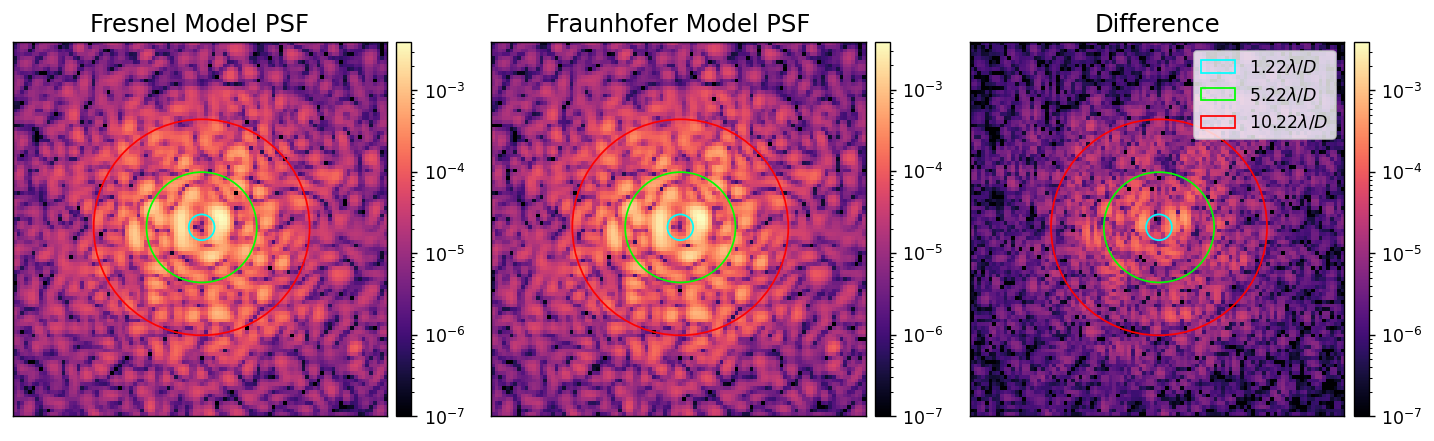

In [5]:
pxscl = coro.psf_pixelscale_lamD
diff = ref_im - model_im
fig,ax = imshow3(ref_im, model_im, xp.abs(diff), 
                'Fresnel Model Coronagraphic Image', 'Fraunhofer Model Coronagraphic Image', 'Difference', 
                lognorm1=True, lognorm2=True, vmin1=1e-7, vmin2=1e-7, 
                lognorm3=True, vmin3=1e-7, vmax3=xp.max(ref_im),
                pxscl=coro.psf_pixelscale_lamD, 
                grid=True,
                patches1=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches2=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', ),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red')],
                patches3=[Circle((pxscl/2, pxscl/2), 1.22, fill=False, color='cyan', label='1.22$\lambda/D$'),
                          Circle((pxscl/2, pxscl/2), 5.22, fill=False, color='lime', label='5.22$\lambda/D$'),
                          Circle((pxscl/2, pxscl/2), 10.22, fill=False, color='red', label='10.22$\lambda/D$')],
                wspace=0.2,
                display_fig=False, return_fig=True,)
fontsize = 14
ax[0].set_title('Fresnel Model PSF', fontsize=fontsize)
ax[1].set_title('Fraunhofer Model PSF', fontsize=fontsize)
ax[2].set_title('Difference',  fontsize=fontsize)
fontsize = 10
ax[2].legend(loc='upper right', fontsize=fontsize)
ticks = np.linspace(-15,15,7)
ticks = []
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[1].set_xticks(ticks)
ax[1].set_yticks(ticks)
ax[2].set_xticks(ticks)
ax[2].set_yticks(ticks)
display(fig)

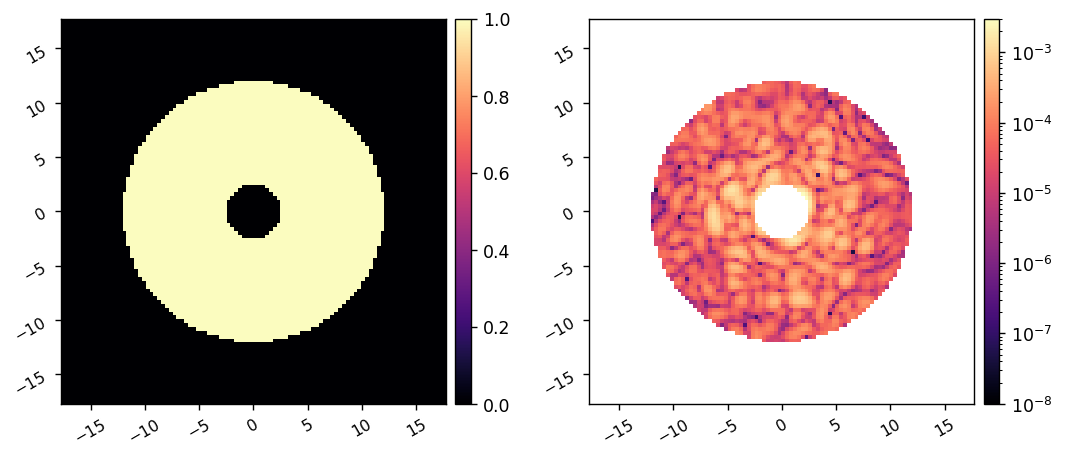

In [6]:
control_mask = efc_utils.create_annular_focal_plane_mask(model, 2.5, 12)
imshow2(control_mask, control_mask*ref_im, lognorm2=True, vmin2=1e-8, pxscl=model.psf_pixelscale_lamD)

In [8]:
poke_modes = efc_utils.create_all_poke_modes(model.dm_mask, ndms=2)


Calculating Jacobian: 
	Calculated response for mode 1904/1904. Elapsed time=86.636 sec.
Jacobian built in 86.636 sec


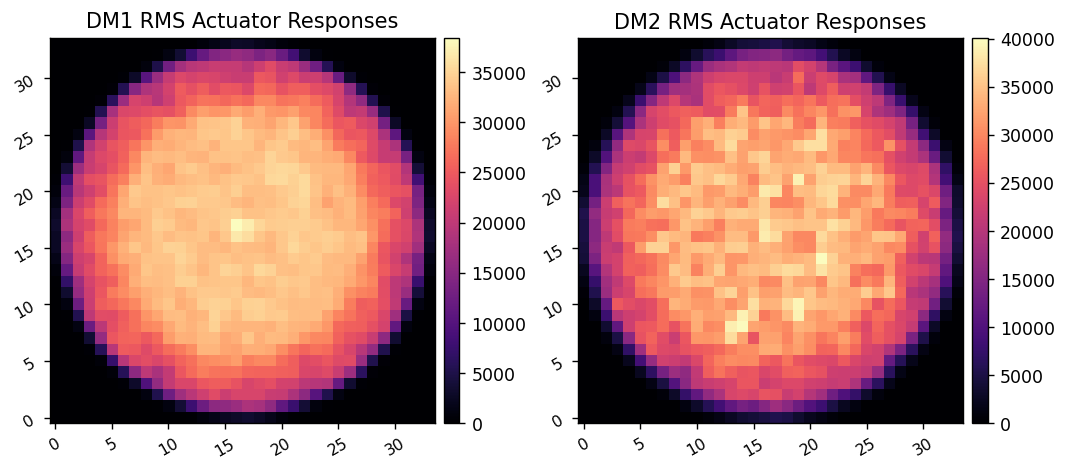

In [9]:
reload(efc)
model.reset_dms()
jac = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

# Run EFC without PWP

In [12]:
coro.reset_dms()
model.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([coro.get_dm1()])
dm2_commands = xp.array([coro.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 7/9.
	Mean NI of this iteration: 8.167e-07


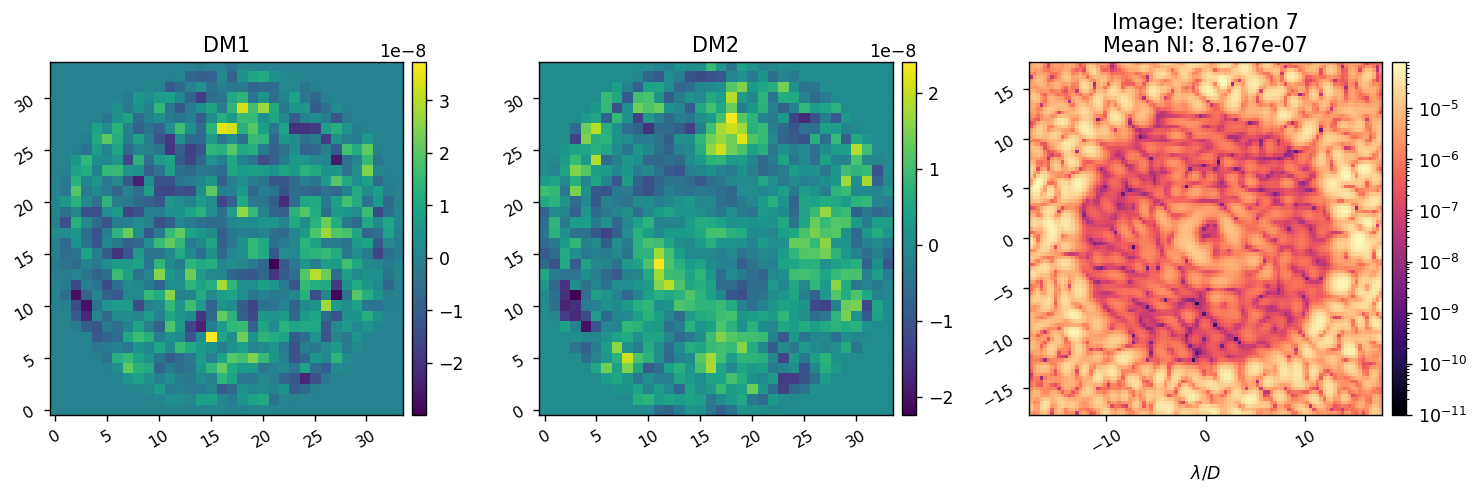

	Running iteration 8/9.
	Mean NI of this iteration: 5.713e-07


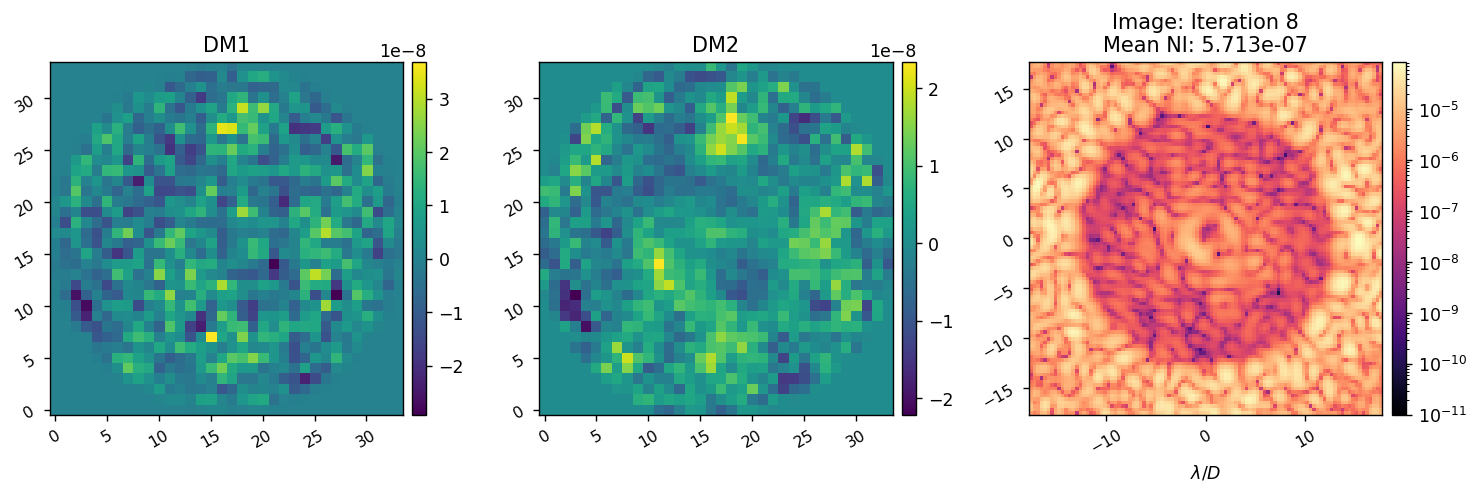

	Running iteration 9/9.
	Mean NI of this iteration: 4.128e-07


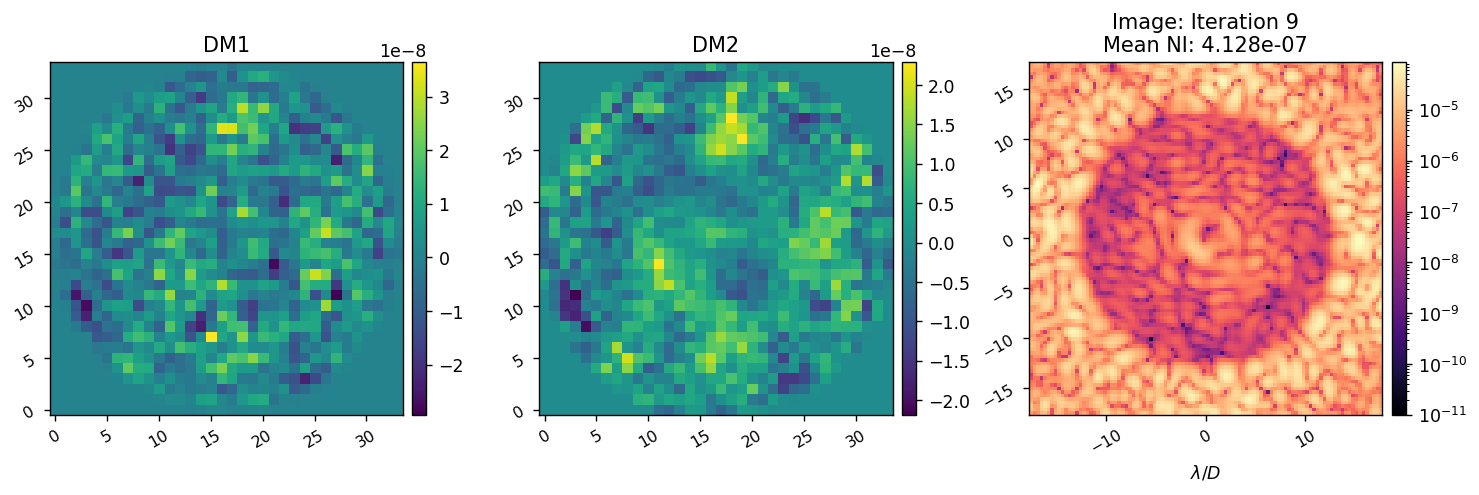

EFC completed in 5.472 sec.


In [58]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc.run(coro, 
                                                    jac, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    control_mask, 
                                                    # est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )

In [64]:
images.shape

(19, 100, 100)

In [65]:
utils.save_fits('../efc-data/efc_1_with_relin_ims.fits', images)
utils.save_fits('../efc-data/efc_1_with_relin_dm1.fits', dm1_commands)
utils.save_fits('../efc-data/efc_1_with_relin_dm2.fits', dm2_commands)

Saved data to:  ../efc-data/efc_1_with_relin_ims.fits
Saved data to:  ../efc-data/efc_1_with_relin_dm1.fits
Saved data to:  ../efc-data/efc_1_with_relin_dm2.fits


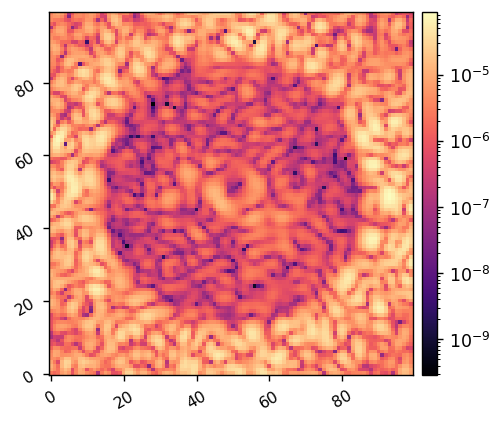

In [59]:
model.set_dm1(coro.get_dm1())
model.set_dm2(coro.get_dm2())

model_im = model.snap()
imshow1(model_im, lognorm=True)

Calculating Jacobian: 
	Calculated response for mode 1904/1904. Elapsed time=90.531 sec.
Jacobian built in 90.531 sec


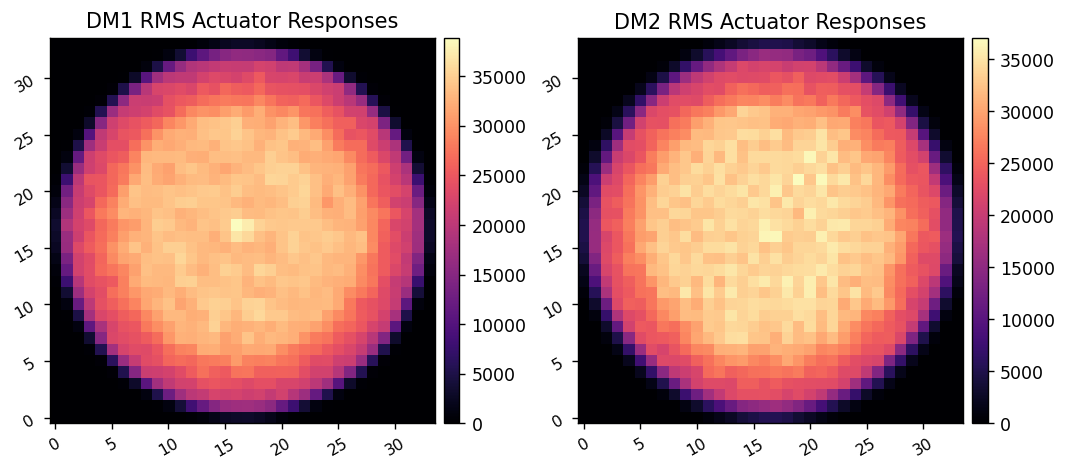

In [60]:
reload(efc)

jac_9 = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

In [41]:
dm1_commands.shape

(37, 34, 34)

Beginning closed-loop EFC simulation.
	Running iteration 16/18.
	Mean NI of this iteration: 5.647e-10


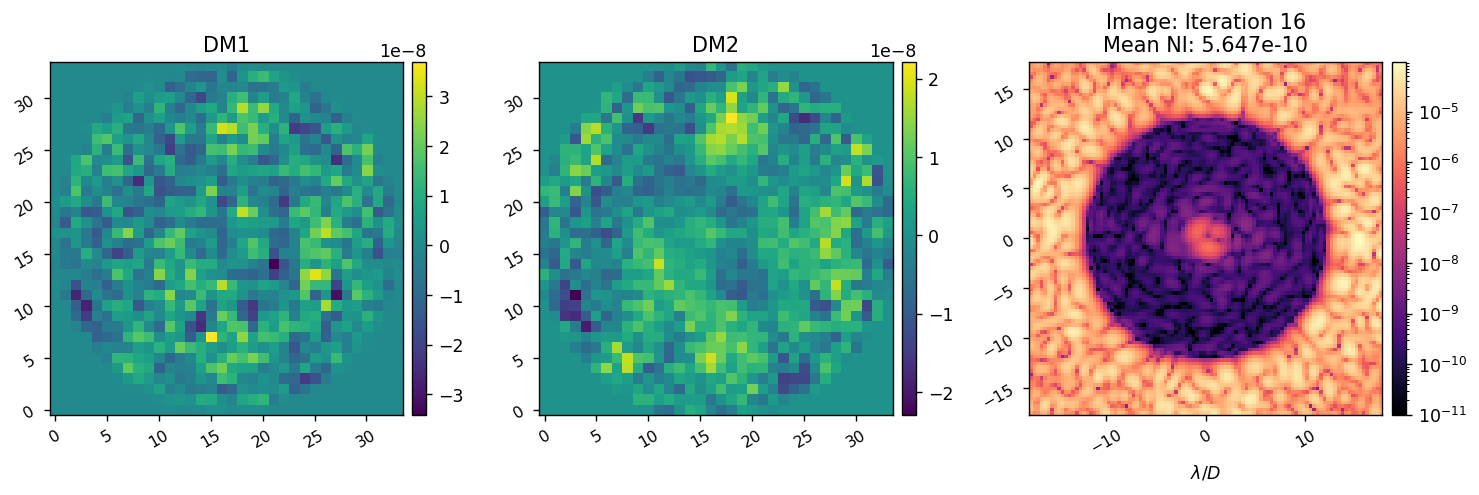

	Running iteration 17/18.
	Mean NI of this iteration: 2.569e-10


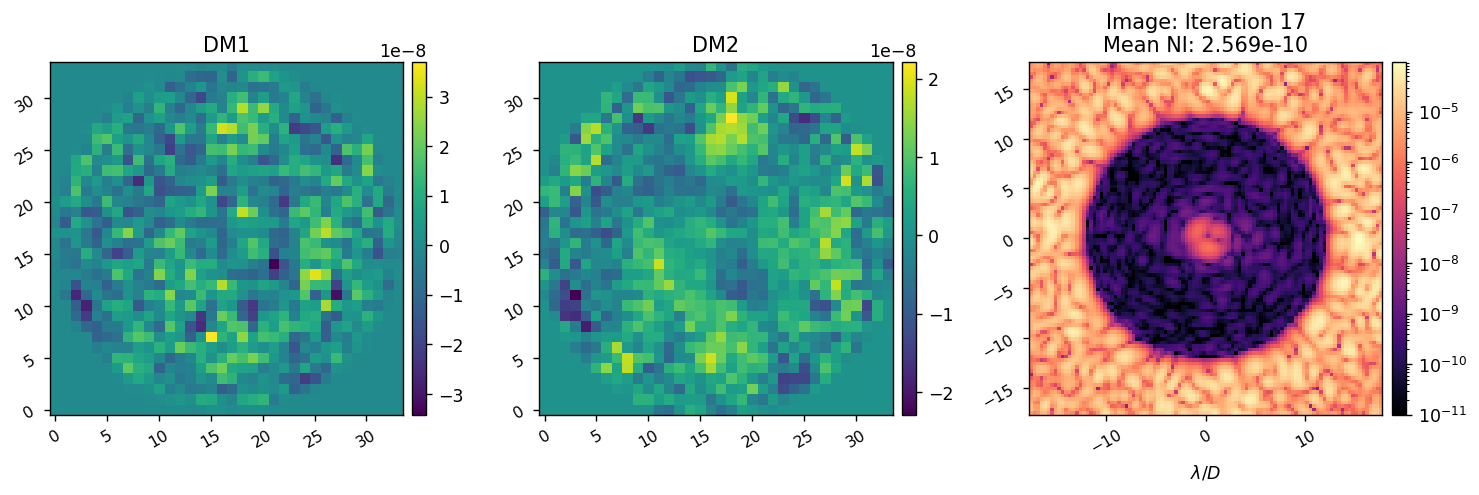

	Running iteration 18/18.
	Mean NI of this iteration: 1.479e-10


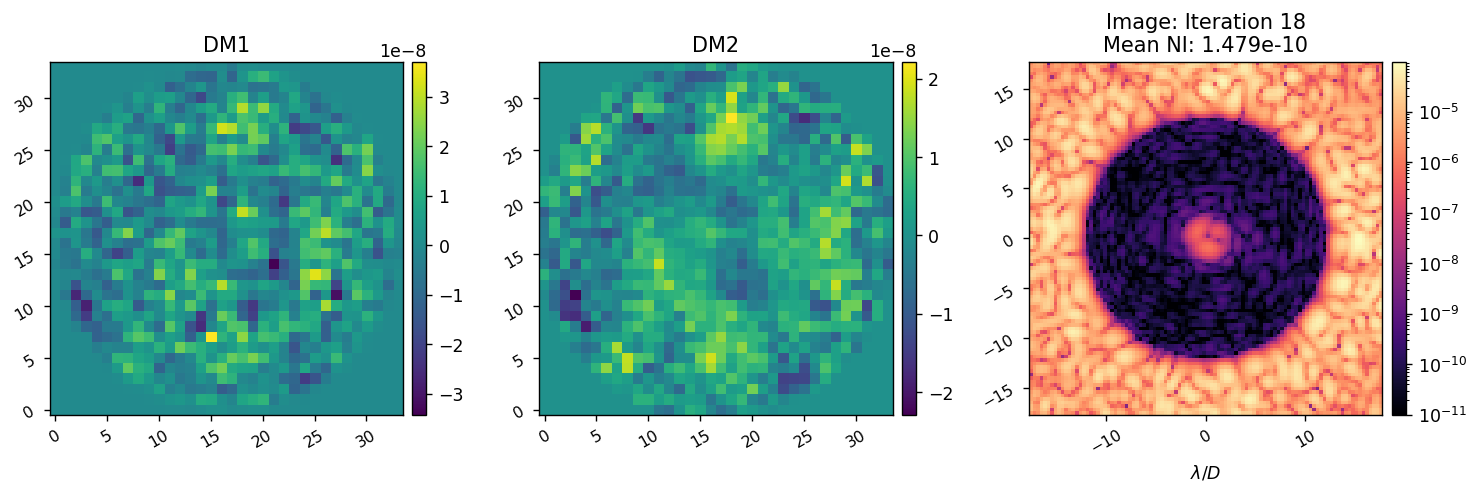

EFC completed in 4.858 sec.


In [63]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc.run(coro, 
                                                    jac_9, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    control_mask, 
                                                    # est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )

In [ ]:
utils.save_fits('../efc-data/efc_1_with_relin_ims.fits', images)
utils.save_fits('../efc-data/efc_1_with_relin_dm1.fits', dm1_commands)
utils.save_fits('../efc-data/efc_1_with_relin_dm2.fits', dm2_commands)

# Inject a small amount of beamwalk that degrades the dark hole and re-dig to maintain the same contrast

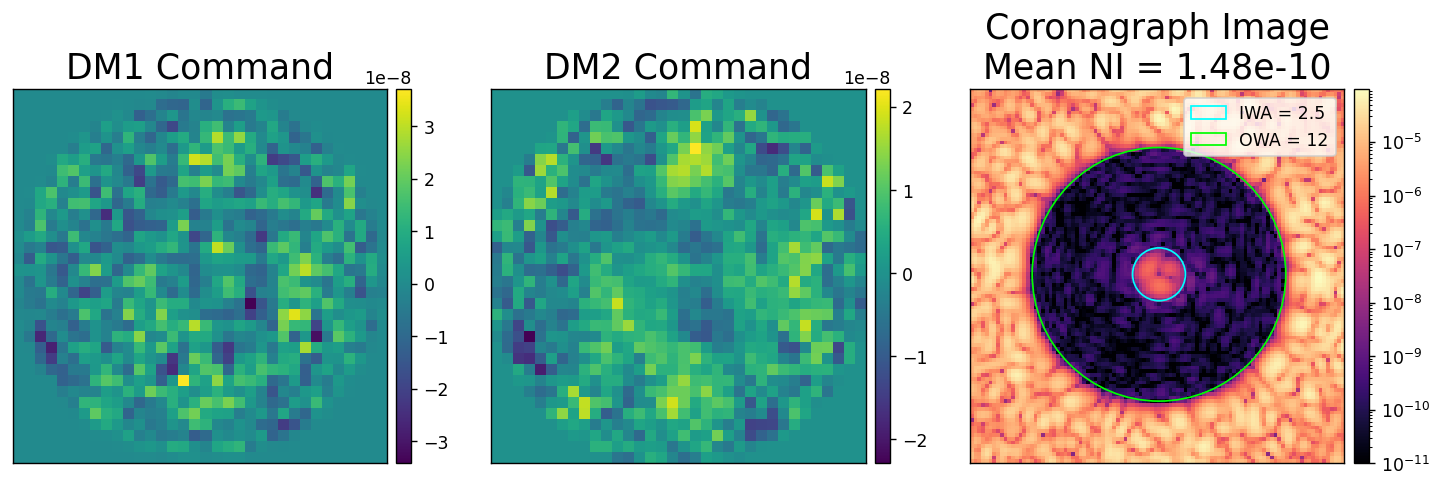

In [9]:
dm1_commands = fits.getdata('../efc-data/efc_1_with_relin_dm1.fits')
dm2_commands = fits.getdata('../efc-data/efc_1_with_relin_dm2.fits')

coro.WFE.amplitude = ote_pupil[0]
coro.WFE.opd = ote_pupil[1]

coro.set_dm1(dm1_commands[-1])
coro.set_dm2(dm2_commands[-1])

dh_image = coro.snap()

mean_ni_dh = xp.mean(dh_image[control_mask])
pxscl = model.psf_pixelscale_lamD

pxscl = coro.psf_pixelscale_lamD
diff = coro_psf - model_psf
fig,ax = imshow3(coro.get_dm1(), coro.get_dm2(), dh_image, 
                cmap1='viridis', cmap2='viridis', cmap3='magma',
                lognorm3=True, vmin3=1e-11,
                pxscl3=coro.psf_pixelscale_lamD, 
                # grid=True,
                patches3=[Circle((pxscl/2, pxscl/2), 2.5, fill=False, color='cyan', label='IWA = 2.5'),
                          Circle((pxscl/2, pxscl/2), 12, fill=False, color='lime', label='OWA = 12'),],
                wspace=0.2,
                display_fig=False, return_fig=True,)
ax[2].legend()
ax[0].set_title('DM1 Command', fontsize=20,)
ax[1].set_title('DM2 Command', fontsize=20,)
ax[2].set_title(f'Coronagraph Image\nMean NI = {mean_ni_dh:.2e}', fontsize=20)
ticks = np.linspace(-15,15,7)
ticks = []
ax[0].set_xticks(ticks)
ax[0].set_yticks(ticks)
ax[1].set_xticks(ticks)
ax[1].set_yticks(ticks)
ax[2].set_xticks(ticks)
ax[2].set_yticks(ticks)
display(fig)

M2 shift in physical units:  0.0012599999999991951 mm 0.0012599999999991951 mm
M3 shift in physical units:  0.013620000000000233 mm 0.013620000000000233 mm
M2 shift in pixels:  0.008822153846148212 pix 0.008822153846148212 pix
M3 shift in pixels:  0.6973440000000118 pix 0.6973440000000118 pix


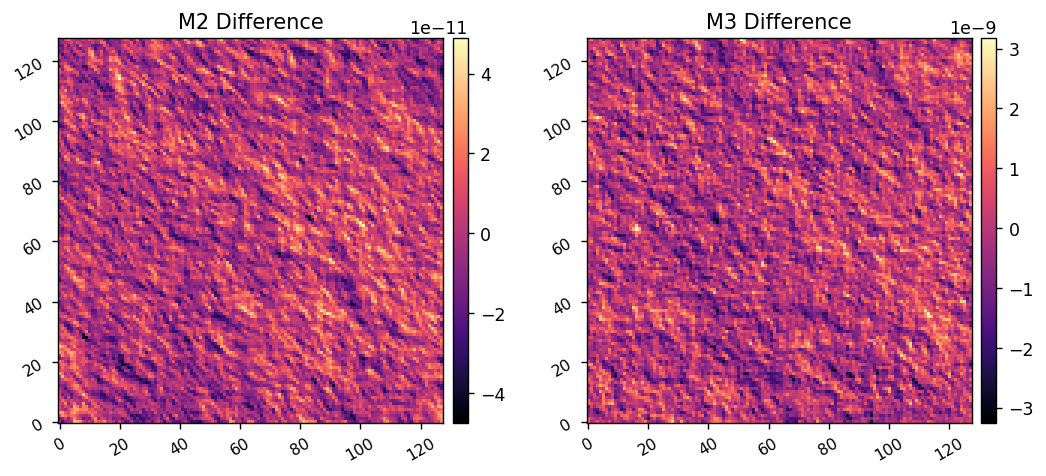

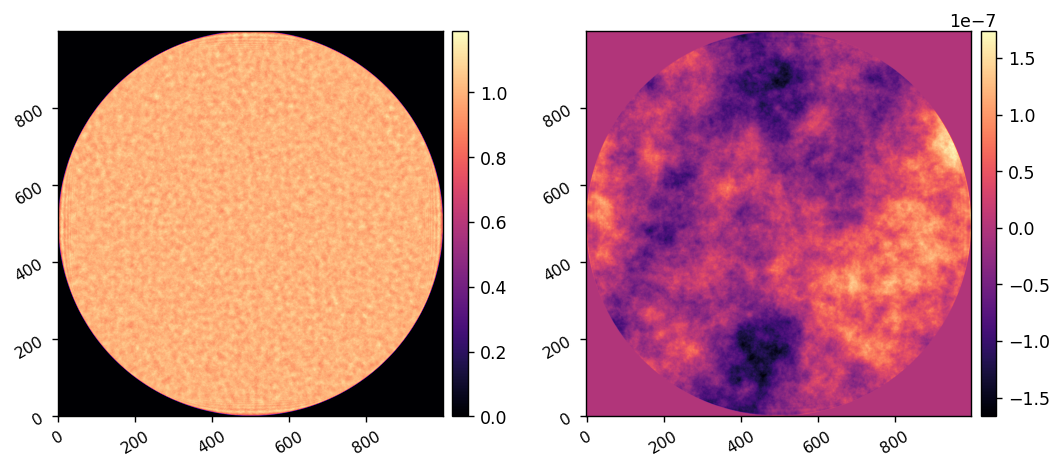

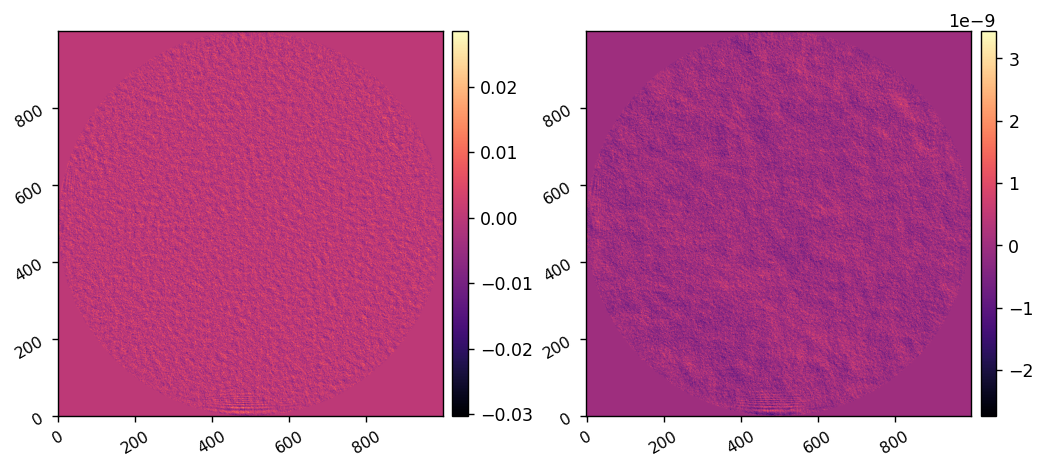

In [10]:
pointing = np.array([15, 15]) * u.mas
ote_bw_pupil = fits.getdata(f'/npool/nvme/kianmilani/wfe-data/telescope_wfe_{pointing[0].value:.0f}mas_{pointing[1].value:.0f}mas.fits')

tmodel.init_opds()
tmodel.shift_surface_errors(pointing, quiet=False, plot=True)

imshow2(ote_bw_pupil[0], ote_bw_pupil[1])
imshow2(ote_pupil[0] - ote_bw_pupil[0], ote_pupil[1] - ote_bw_pupil[1])


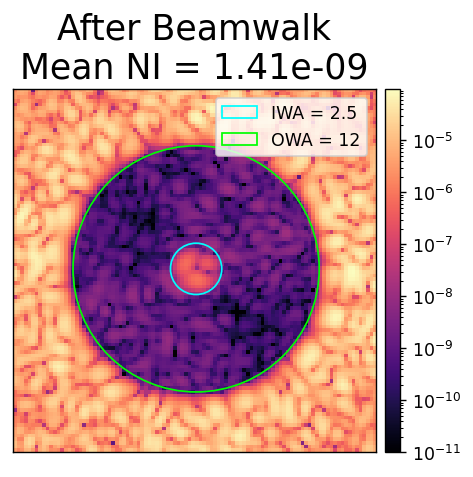

In [11]:
coro.WFE.amplitude = ote_bw_pupil[0]
coro.WFE.opd = ote_bw_pupil[1]

bw_image = coro.snap()
mean_ni_bw = xp.mean(bw_image[control_mask])
fig,ax = imshow1(bw_image, cmap='magma', lognorm=True, vmin=1e-11,
                pxscl=coro.psf_pixelscale_lamD, 
                patches=[Circle((pxscl/2, pxscl/2), 2.5, fill=False, color='cyan', label='IWA = 2.5'),
                         Circle((pxscl/2, pxscl/2), 12, fill=False, color='lime', label='OWA = 12'),],
                display_fig=False, return_fig=True,)
ax.legend()
ax.set_title(f'After Beamwalk\nMean NI = {mean_ni_bw:.2e}', fontsize=20)
ticks = np.linspace(-15,15,7)
ticks = []
ax.set_xticks(ticks)
ax.set_yticks(ticks)
display(fig)

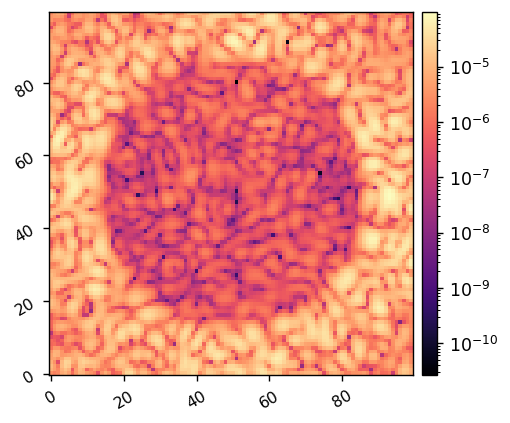

In [18]:
model.set_dm1(coro.get_dm1())
model.set_dm2(coro.get_dm2())
model.use_fpm = True
model_im = model.snap()
imshow1(model_im, lognorm=True)

In [ ]:
reload(efc)

jac_final = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

In [20]:
utils.save_fits('../efc-data/smallDM_jac_final.fits', jac_final)

Saved data to:  ../efc-data/smallDM_jac_final.fits


In [12]:
jac_final = xp.array(fits.getdata('../efc-data/smallDM_jac_final.fits'))


In [13]:
coro.reset_dms()
dm1_commands = fits.getdata('../efc-data/efc_1_with_relin_dm1.fits')
dm2_commands = fits.getdata('../efc-data/efc_1_with_relin_dm2.fits')

coro.WFE.amplitude = ote_bw_pupil[0]
coro.WFE.opd = ote_bw_pupil[1]

coro.set_dm1(dm1_commands[-1])
coro.set_dm2(dm2_commands[-1])

new_images = xp.array([bw_image])
new_dm1_commands = xp.array([coro.get_dm1()])
new_dm2_commands = xp.array([coro.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 1/3.
	Mean NI of this iteration: 4.528e-10


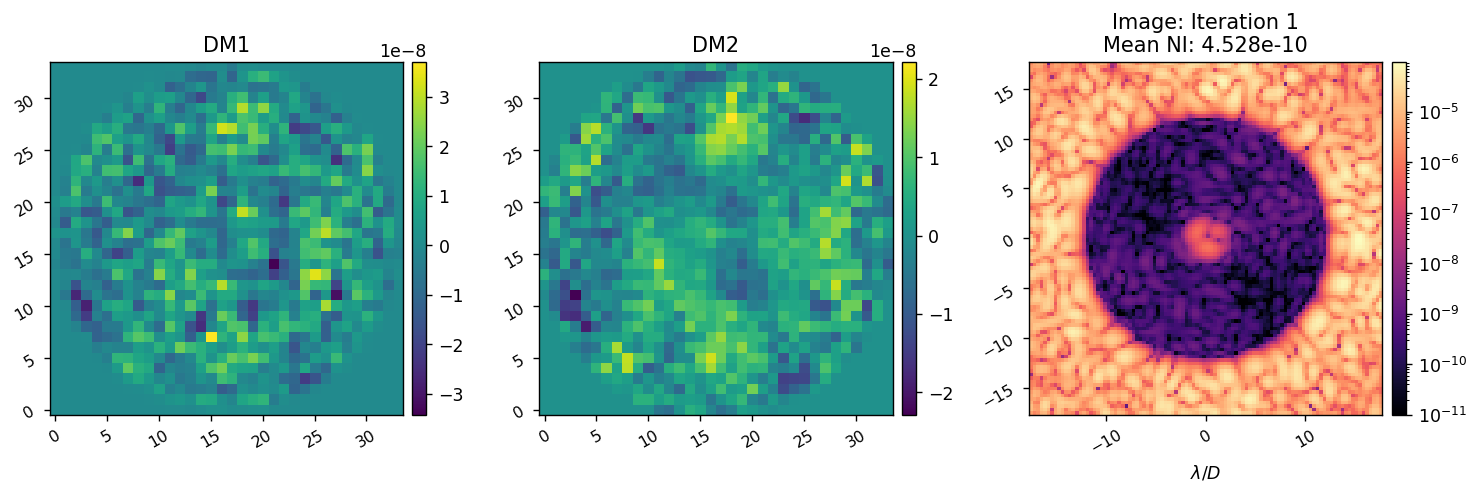

	Running iteration 2/3.
	Mean NI of this iteration: 1.859e-10


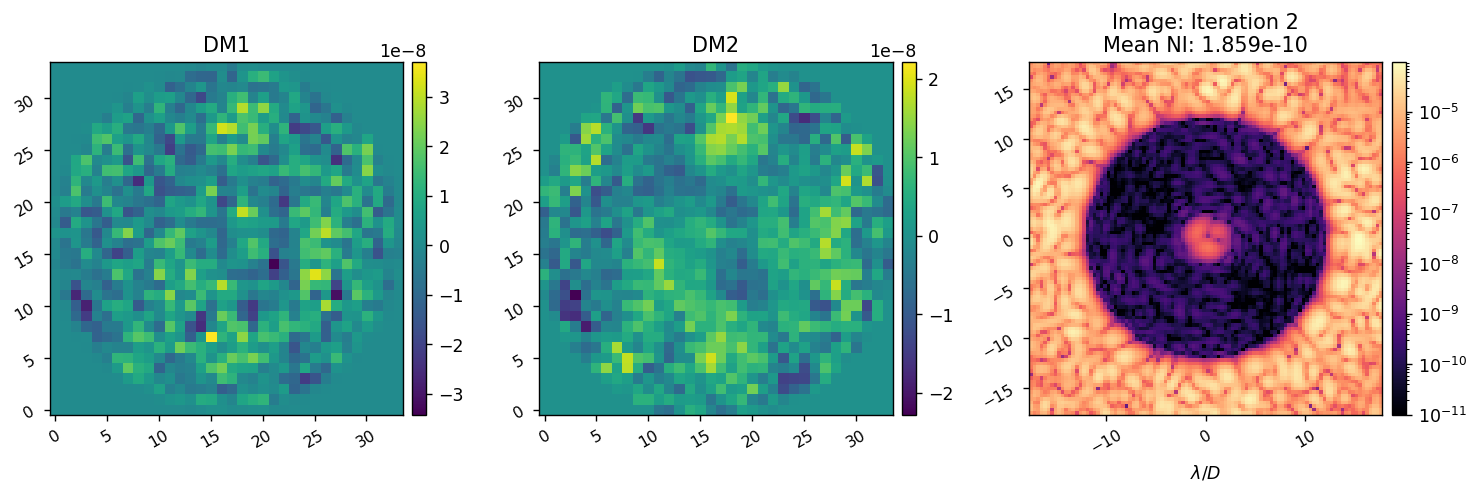

	Running iteration 3/3.
	Mean NI of this iteration: 1.091e-10


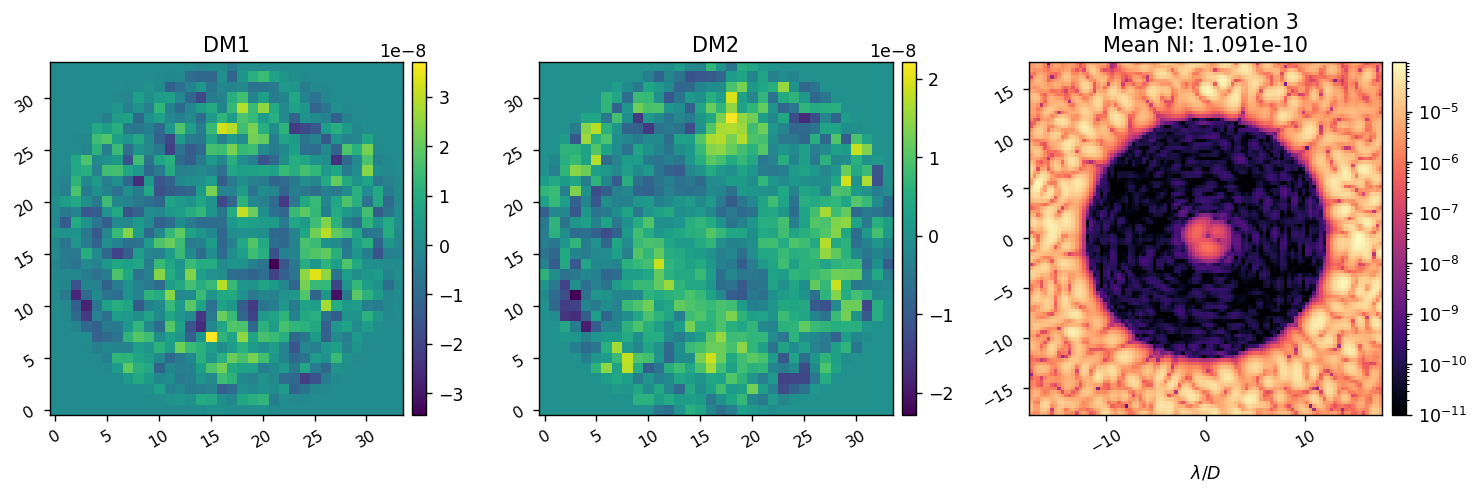

EFC completed in 4.213 sec.


In [14]:
reg_fun = efc_utils.beta_reg
# reg_conds = -1
# reg_conds = -2
reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

new_images, new_dm1_commands, new_dm2_commands, regs = efc.run(coro, 
                                                    jac_final, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    control_mask, 
                                                    # est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=new_images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=new_dm1_commands,
                                                    old_dm2_commands=new_dm2_commands,
                                                    old_regs=regs,
                                                    )

In [15]:
utils.save_fits('../efc-data/smallDM_efc_afterBW_ims.fits', new_images)
utils.save_fits('../efc-data/smallDM_efc_afterBW_dm1.fits', new_dm1_commands)
utils.save_fits('../efc-data/smallDM_efc_afterBW_dm2.fits', new_dm2_commands)

Saved data to:  ../efc-data/smallDM_efc_afterBW_ims.fits
Saved data to:  ../efc-data/smallDM_efc_afterBW_dm1.fits
Saved data to:  ../efc-data/smallDM_efc_afterBW_dm2.fits


# Run EFC with PWP

## Test PWP

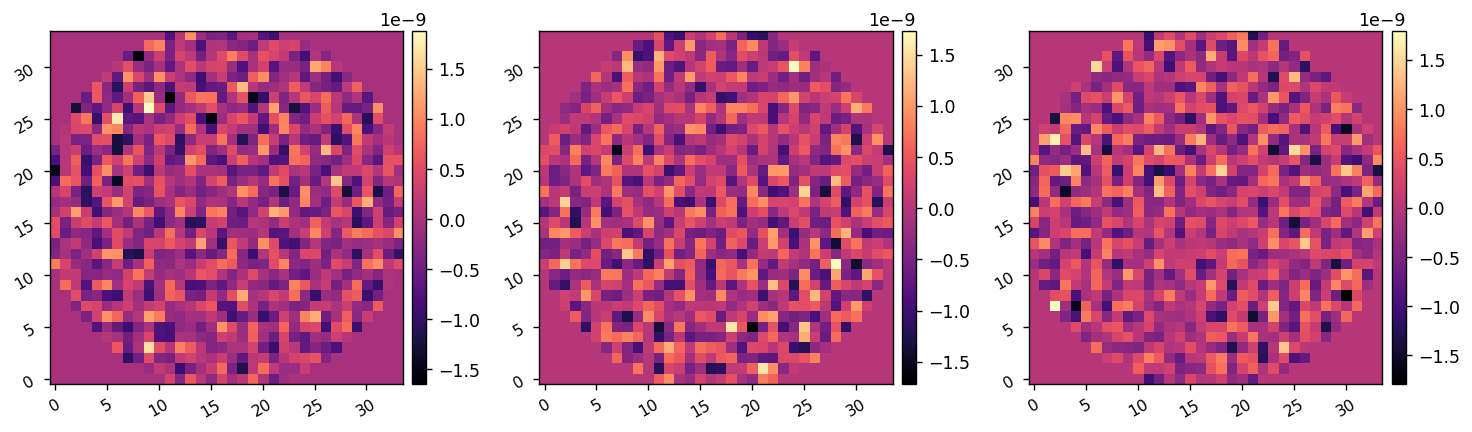

1.0

In [63]:
reload(efc_utils)
Npairs = 4

# probe_amp = 10e-9
# probe_mask = efc_utils.create_annular_focal_plane_mask(model, inner_radius=2, outer_radius=13, edge=0, plot=True)
# probe_modes = efc_utils.create_fourier_probes(model, probe_mask, fourier_sampling=0.25, 
#                                                shift=[(-8, 8), (8,8), (-8,-8), (8,-8),], 
#                                                nprobes=Npairs, 
#                                                use_weighting=True,
#                                                )
# probes = probe_amp * probe_modes
# imshow3(probes[0], probes[1], probes[3])

probe_modes = efc_utils.create_random_probes(rms=probe_amp, alpha=3, dm_mask=model.dm_mask, fmin=1.5, fmax=14, nprobes=3)
probe_modes /= np.sqrt(np.mean(np.square(probe_modes[0])))
probe_amp = 5e-10
probes = probe_amp * probe_modes
imshow3(probes[0], probes[1], probes[2])

np.sqrt(np.mean(np.square(probe_modes[0])))

In [47]:

np.sqrt(np.mean(np.square(probe_modes[0])))

1.0

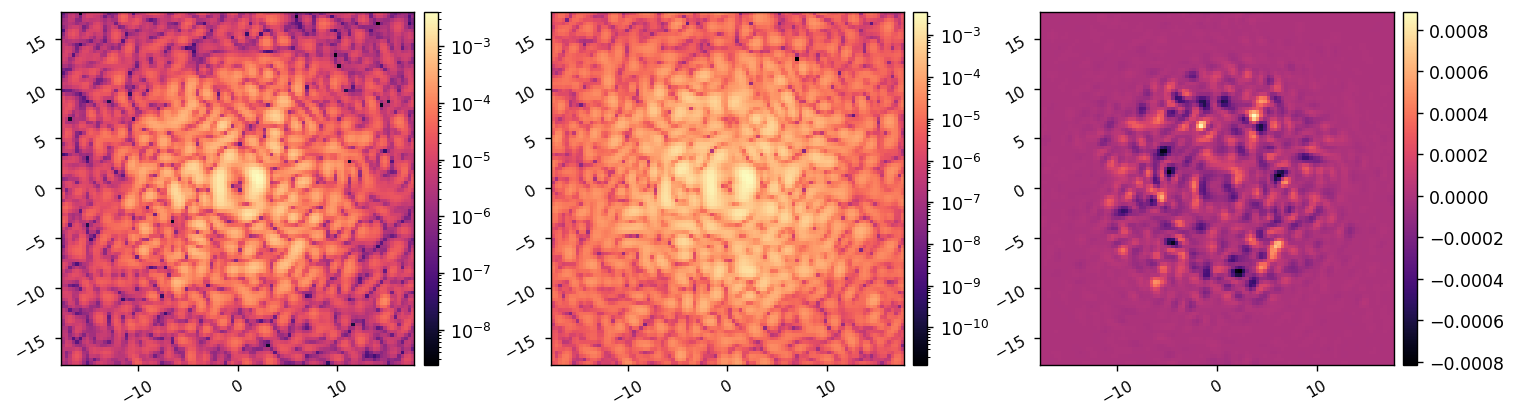

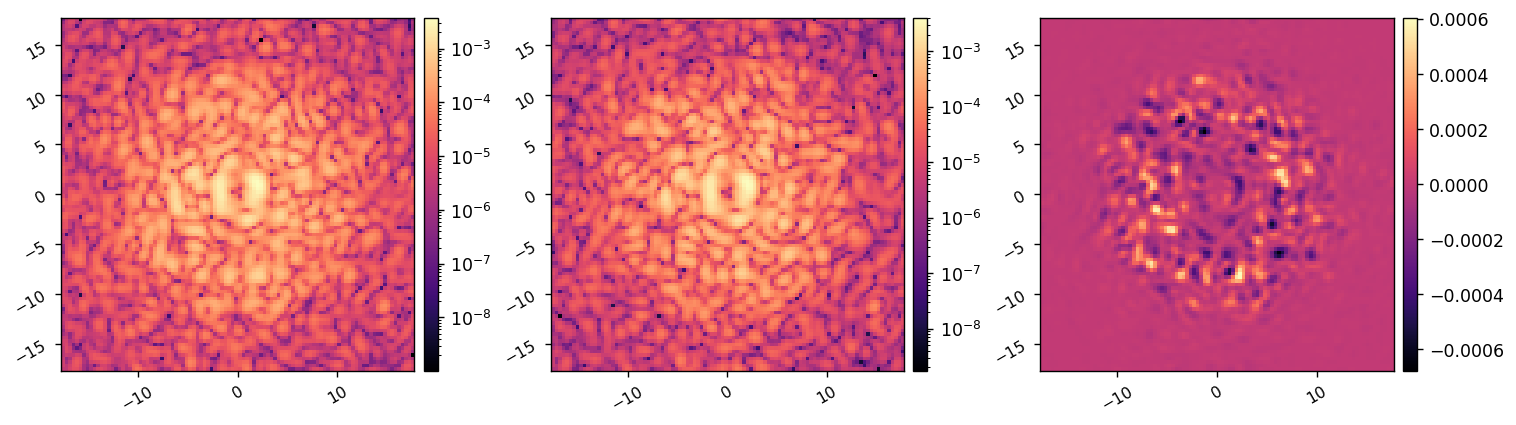

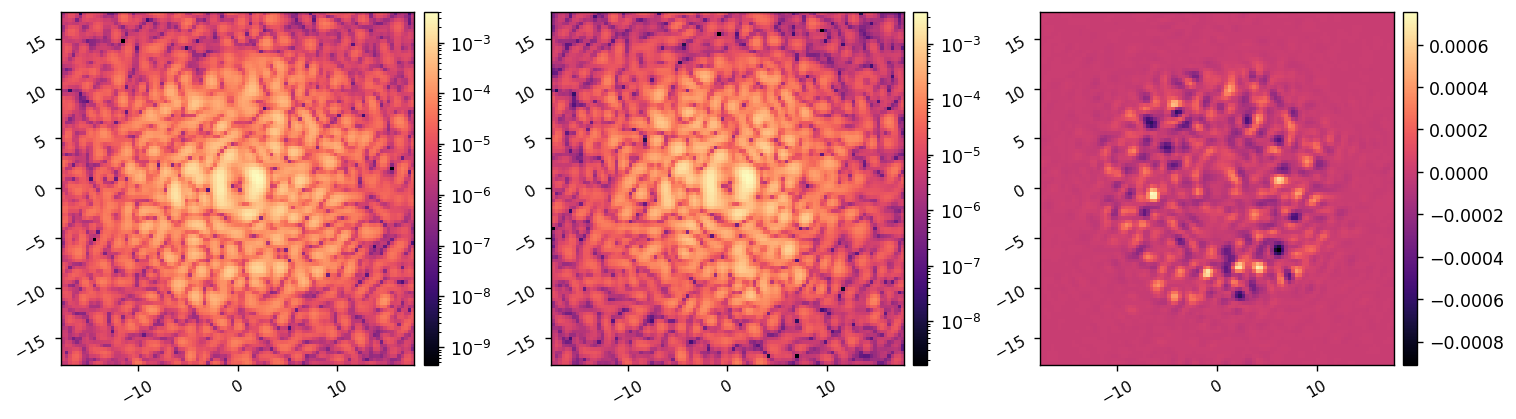

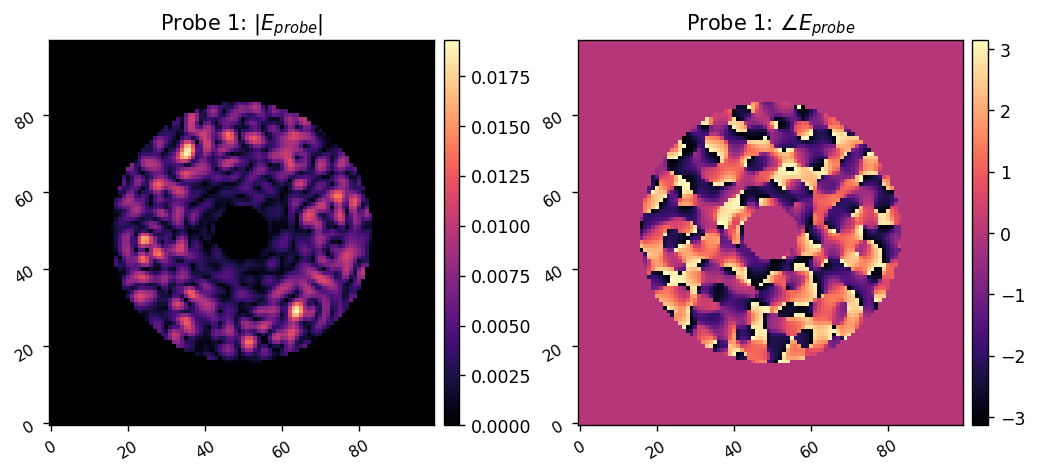

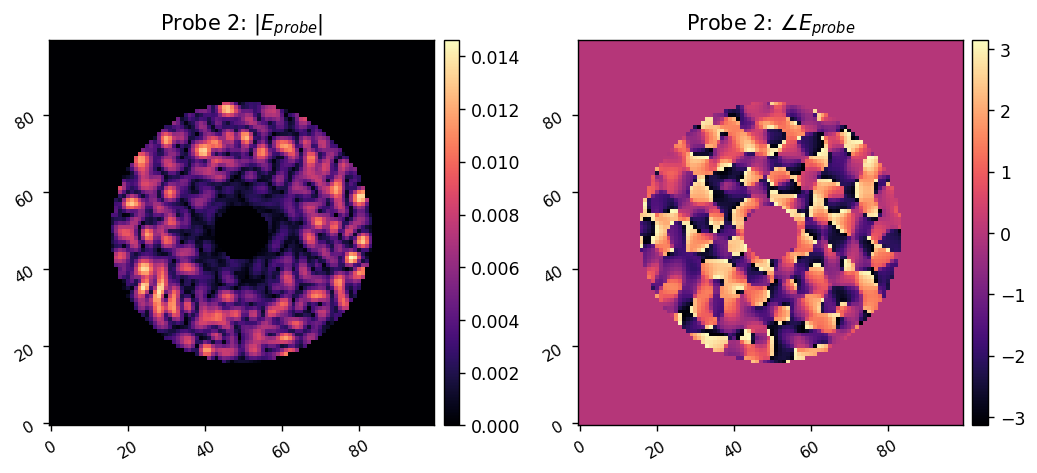

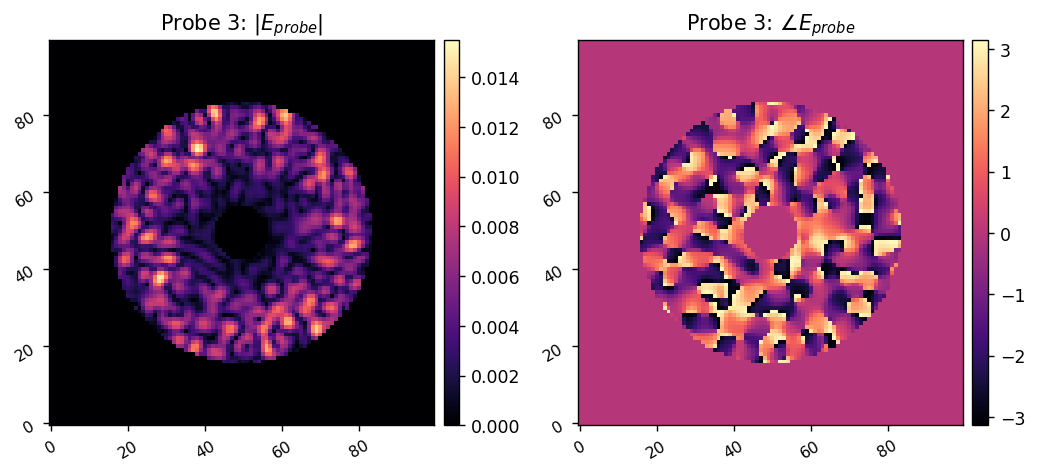

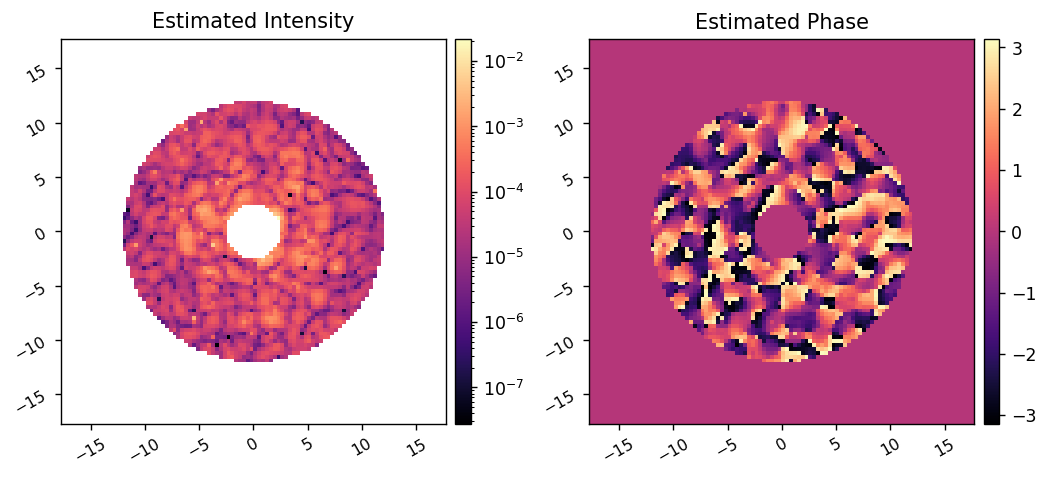

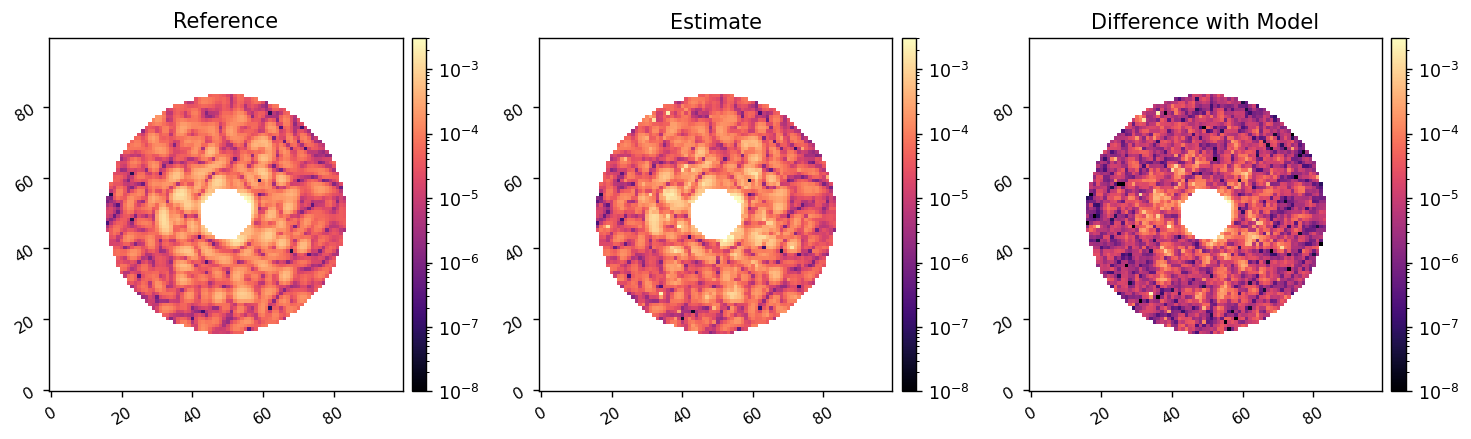

In [66]:
reload(pwp)
coro.reset_dms()

probe_amp = 5e-9
E_est = pwp.run_pwp_bp(coro, control_mask, probe_amp*probe_modes, use='J', jacobian=jac, 
                       reg_cond=1e-5,
                       plot=True,
                       plot_est=True,
                       )
I_est = np.abs(E_est)**2
P_est = np.angle(E_est)

diff = ref_im*control_mask - I_est
# vmax = xp.max(xp.concatenate([ref_im*control_mask, I_est]))
vmax = xp.max(ref_im*control_mask)
imshow3(ref_im*control_mask, I_est, xp.abs(diff),
        'Reference', 'Estimate', 'Difference with Model',
        lognorm=True, 
        vmax1=vmax, vmax2=vmax, vmax3=vmax,
        vmin1=1e-8, vmin2=1e-8, vmin3=1e-8)

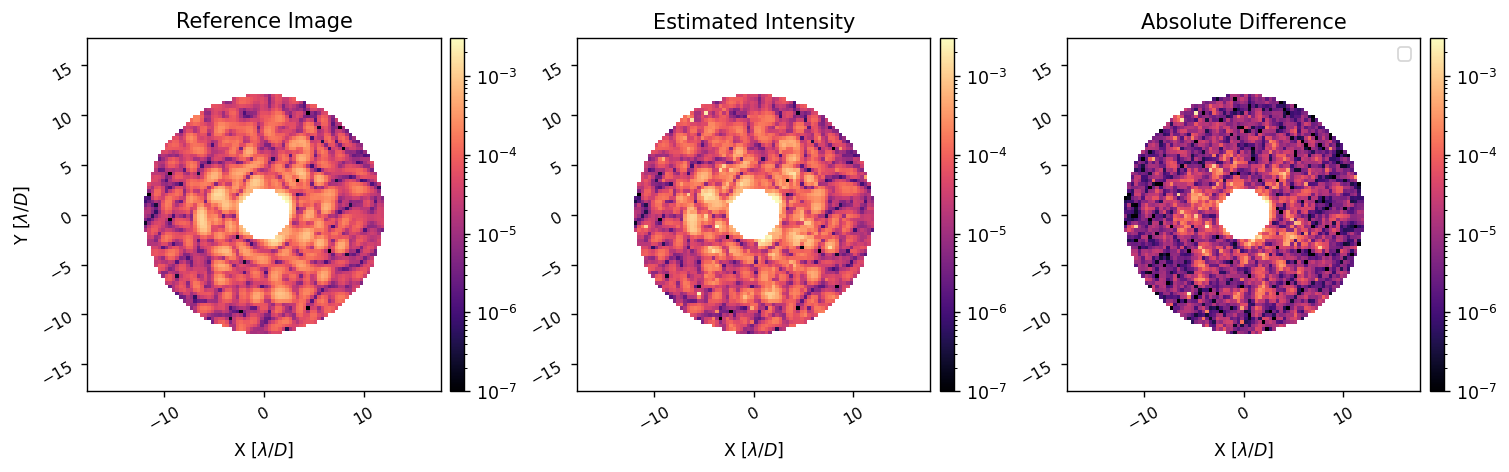

In [67]:
vmax = xp.max(ref_im*control_mask)
fig,ax = imshow3(ref_im*control_mask, I_est, xp.abs(diff),
                'Reference Image', 'Estimated Intensity', 'Absolute Difference',
                lognorm=True, 
                vmax1=vmax, vmax2=vmax, vmax3=vmax,
                vmin1=1e-7, vmin2=1e-7, vmin3=1e-7,
                pxscl=coro.psf_pixelscale_lamD, 
                # grid=True,
                wspace=0.3,
                display_fig=False, return_fig=True,)
ax[2].legend()
# ax[0].set_title('DM1 Command', fontsize=20,)
# ax[1].set_title('DM2 Command', fontsize=20,)
# ax[2].set_title(f'Coronagraph Image\nMean NI = {mean_ni_dh:.2e}', fontsize=20)
ticks = np.linspace(-15,15,7)
ax[0].set_ylabel('Y [$\lambda/D$]')
ax[0].set_xlabel('X [$\lambda/D$]')
ax[1].set_xlabel('X [$\lambda/D$]')
ax[2].set_xlabel('X [$\lambda/D$]')
# ticks = []
# ax[0].set_xticks(ticks)
# ax[0].set_yticks(ticks)
# ax[1].set_xticks(ticks)
# ax[1].set_yticks(ticks)
# ax[2].set_xticks(ticks)
# ax[2].set_yticks(ticks)
display(fig)

In [43]:
64 * 0.4

25.6

# Run EFC without PWP

In [ ]:
coro.reset_dms()
model.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([coro.get_dm1()])
dm2_commands = xp.array([coro.get_dm2()])
regs = xp.array([])

In [18]:
coro.reset_dms()
model.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([coro.get_dm1()])
dm2_commands = xp.array([coro.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 19/21.


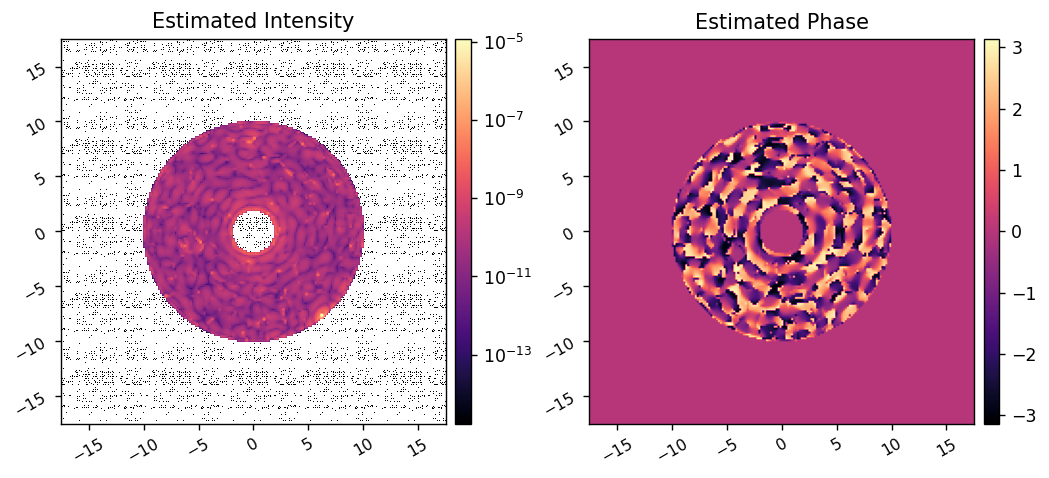

	Mean NI of this iteration: 2.056e-10


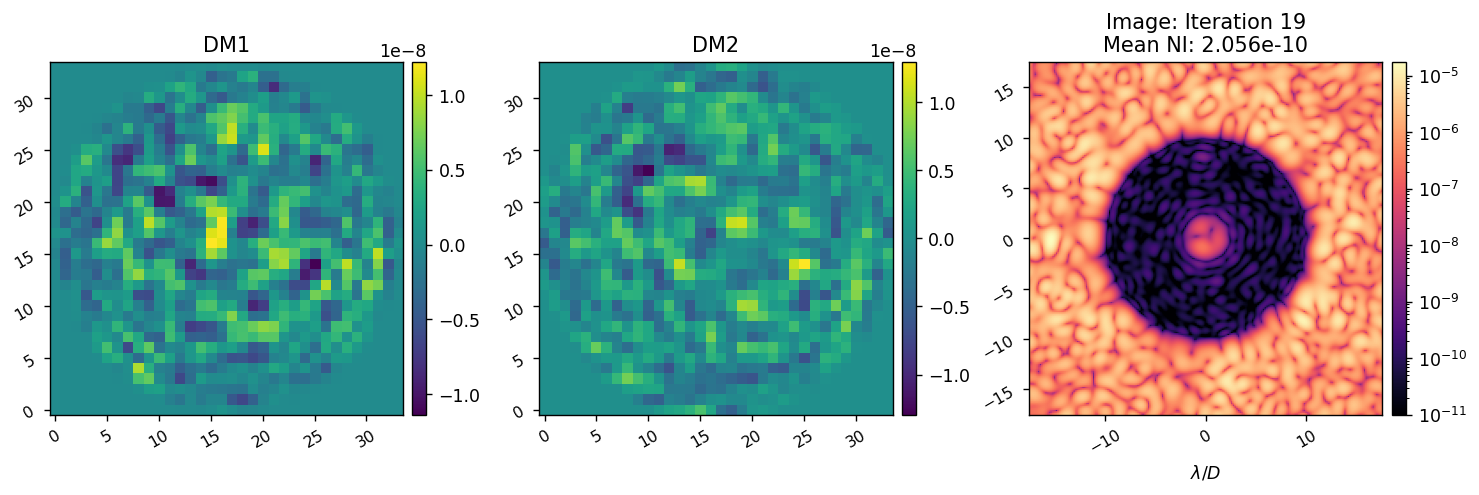

	Running iteration 20/21.


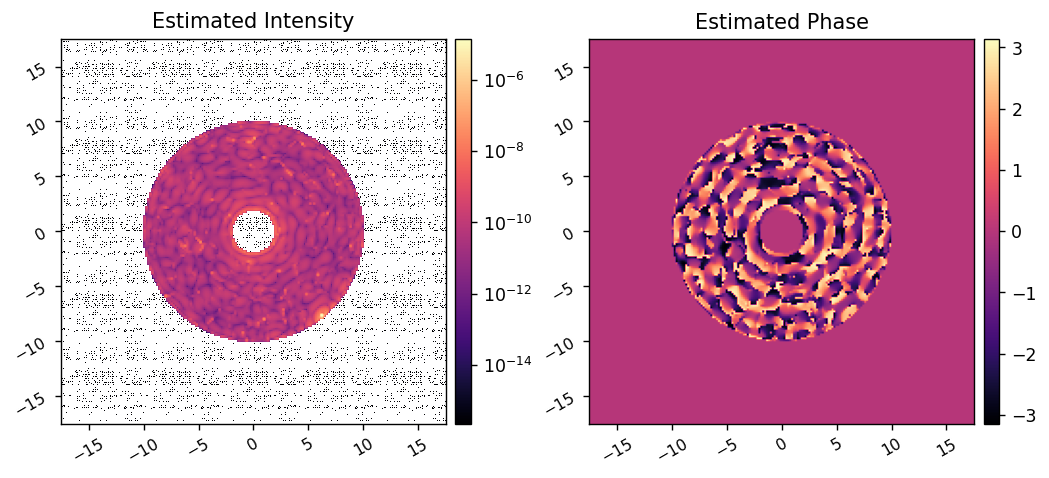

	Mean NI of this iteration: 2.152e-10


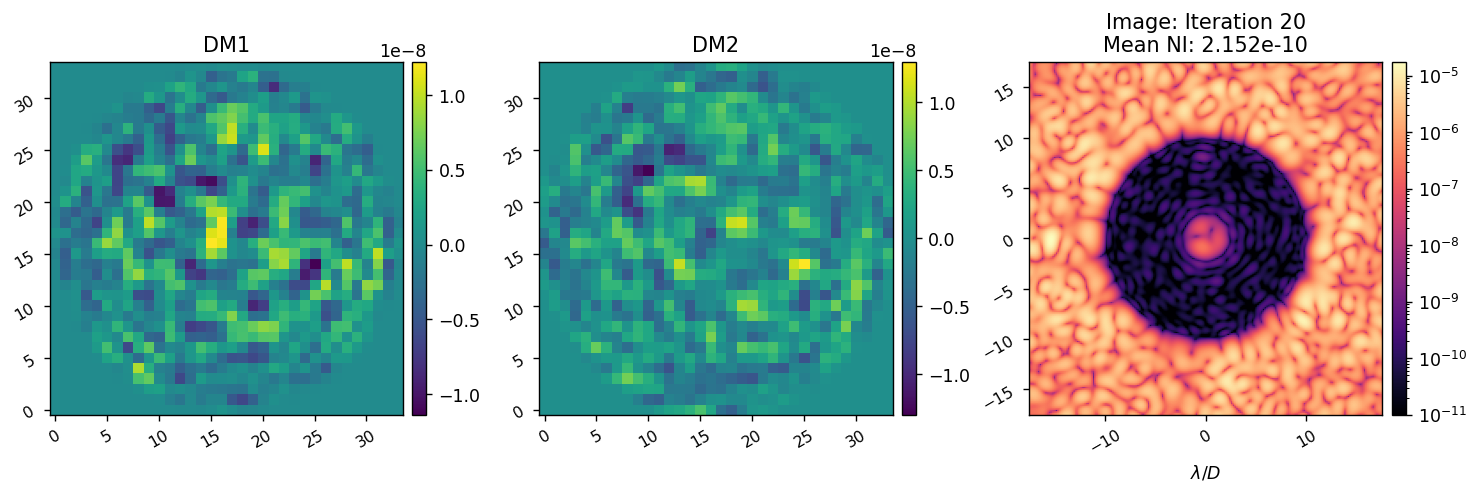

	Running iteration 21/21.


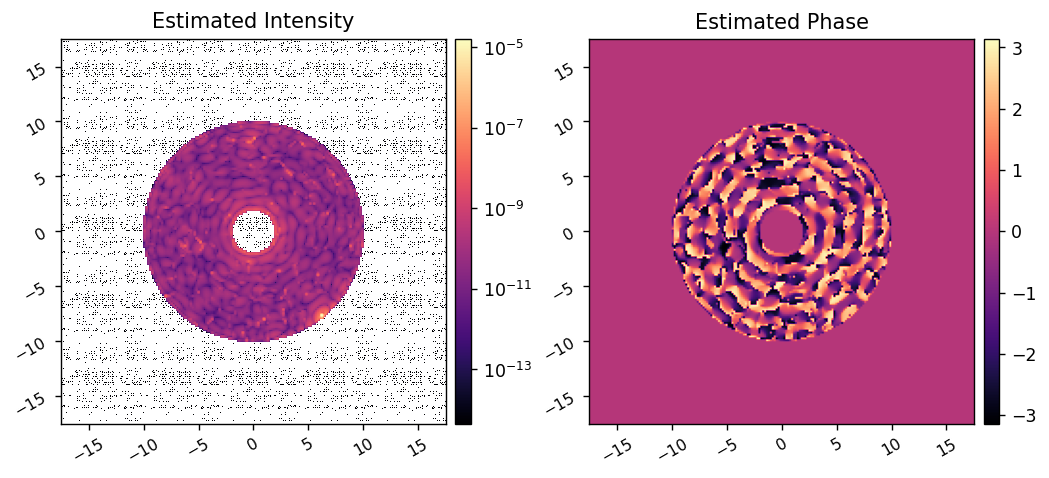

	Mean NI of this iteration: 2.298e-10


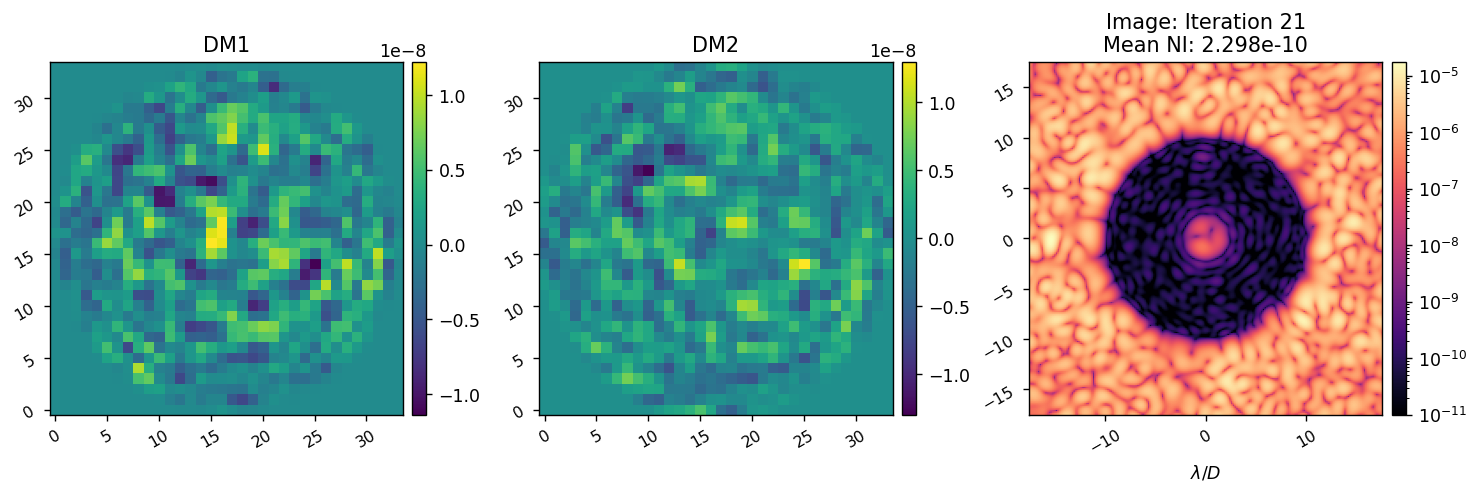

EFC completed in 32.796 sec.


In [25]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
reg_conds = -2
# reg_conds = -2.5
# reg_conds = -3
# reg_conds = -3.5
# reg_conds = -4
# reg_conds = -4.5
# reg_conds = -5

pwp_fun = pwp.run_pwp_bp

pwp_reg = 1e-8
pwp_params = {
    'control_mask':control_mask,  
    'probes':probes/4,
    'use':'J', 
    'jacobian':jac,
    'reg_cond':pwp_reg, 
    'plot_est':True,
}

images, dm1_commands, dm2_commands, regs = efc.run(coro, 
                                                    jac, 
                                                    reg_fun, reg_conds,
                                                    poke_modes,
                                                    control_mask, 
                                                    est_fun=pwp_fun, est_params=pwp_params,
                                                    Imax_unocc=1,
                                                    loop_gain=0.5, 
                                                    leakage=0.0,
                                                    iterations=3, 
                                                    plot_all=True, 
                                                    # plot_sms=True,
                                                    # plot_radial_contrast=True,
                                                    old_images=images,
                                                    # old_efields=efields,
                                                    old_dm1_commands=dm1_commands,
                                                    old_dm2_commands=dm2_commands,
                                                    old_regs=regs,
                                                    )